# Introduction
Here I pseudobulk by cell type-condition so that we can run DESeq2 on the mRNA and ADTs.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import seaborn as sns
import pickle as pkl
from functools import reduce
import anndata
from nero import Octavia

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=30

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

In [4]:
Octavia.set_mountpoint(mountpoint)

## Load in Data, Make Raw Data

In [5]:
path = prefix_comb + 'h5ads/concat_5.h5ad'
concat = sc.read_h5ad(path)

In [6]:
raw_mrna = Octavia.get_raw_mrna(concat.obs_names).copy()

In [7]:
raw_adts = Octavia.get_raw_adts(concat.obs_names).copy()

# Organize Raw Data by Cell Type and Condition

## `ct2`

### mRNA

#### Processing

Prepare `df`s.

In [75]:
ct_type = 'ct2'

In [76]:
raw_mrna.obs[ct_type] = concat.obs[ct_type]

In [77]:
conds = concat.obs['cond'].dtype.categories
clusts = concat.obs[ct_type].dtype.categories

In [78]:
cond_ct_df = pd.DataFrame(index=conds, columns=clusts, dtype=np.int)

Get cell numbers.

In [79]:
for cond in tqdm(conds):
    for clust in clusts:
        cond_ct_df.loc[cond, clust] = concat[(concat.obs['cond'] == cond) & (concat.obs[ct_type] == clust)].shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

Divide by the total per cell type, then remove small populations we don't want to run DE on.

In [80]:
cond_ct_df_div = cond_ct_df.divide(cond_ct_df.sum(0),1)

In [81]:
high_count_cts = concat.obs[ct_type].value_counts().drop(['Plasma', 'Mitotic']).index.tolist()
print(high_count_cts)

['T4_Naive', 'T4_EM', 'cM', 'T8_Naive', 'T_Tox', 'B_Naive', 'NK', 'B_Mem', 'cDC', 'ncM', 'pDC', 'Mye_PMAI', 'HSC']


In [82]:
free_ids = np.unique(concat.obs['free_id'].values)
ind_ct = pd.DataFrame(0, index=free_ids, columns=high_count_cts)

In [83]:
for free_id, ct in tqdm(it.product(free_ids, high_count_cts)):
    ind_ct.loc[free_id, ct] = len(concat.obs[(concat.obs['free_id'] == free_id) & (concat.obs[ct_type] == ct)])

0it [00:00, ?it/s]

In [84]:
ct_cond_id = list(it.product(high_count_cts, ['A', 'B', 'C', 'G', 'P', 'R'], free_ids))

In [85]:
ct_cond_id_df = pd.DataFrame(ct_cond_id, columns=['CT','COND', 'FID'])

In [86]:
ct_cond_id_df

,CT,COND,FID
0,T4_Naive,A,0
1,T4_Naive,A,1
2,T4_Naive,A,10
3,T4_Naive,A,11
4,T4_Naive,A,12
...,...,...,...
4987,HSC,R,62
4988,HSC,R,63
4989,HSC,R,7
4990,HSC,R,8


Now get the actual transcript numbers.

In [87]:
counts_genes = list()
cell_counts = list()
for ct, cond, free_id in tqdm(ct_cond_id):
    arr = raw_mrna[(raw_mrna.obs[ct_type] == ct) & (raw_mrna.obs['cond'] == cond) & (raw_mrna.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

  0%|          | 0/4992 [00:00<?, ?it/s]

In [88]:
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_mrna.var_names))

In [89]:
lot = list()
for i in ct_cond_id_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

In [90]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'Mye_PMAI-A', 'Mye_PMAI-B', 'Mye_PMAI-C', 'Mye_PMAI-G',
        'Mye_PMAI-P', 'Mye_PMAI-R', 'NK-A', 'NK-B', 'NK-C', 'NK-G', 'NK-P',
        'NK-R', 'T4_EM-A', 'T4_EM-B', 'T4_EM-C', 'T4_EM-G', 'T4_EM-P',
        'T4_EM-R', 'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C', 'T4_Naive-G',
        'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A', 'T8_Naive-B',
        'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P', 'T8_Naive-R', 'T_Tox-A',
        'T_Tox-B', 'T_Tox-C', 'T_Tox-G', 'T_Tox-P', 'T_Tox-R', 'cDC-A',
        'cDC-B', 'cDC-C', 'cDC-G', 'cDC-P', 'cDC-R', 'cM-A', 'cM-B',
        'cM-C', 'cM-G', 'cM-P', 'cM-R', 'ncM-A', 'ncM-B', 'ncM-C', 'ncM-G',
        'ncM-P', 'ncM-R', 'pDC-A', 'pDC-B', 'pDC-C', 'pDC-G', 'pDC-P',
        'pDC-R'], dtype='<U10'),
 array([64, 64, 64, 64, 64, 64, 

Because the PMA/I monocytes and cDCs (`Mye_PMAI`)didn't separate out and are grouped together in the final object, we still want to compare them to the other conditions but make sure the populations in other conditions are comparable. Therefore, I will make equivalent populations in the other conditions.

In [91]:
ct_cond_id_df[ct_cond_id_df['CT'] == 'Mye_PMAI']

,CT,COND,FID,NUM_CELLS,AL627309.1,AL627309.3,AL669831.5,LINC00115,FAM41C,AL645608.3,...,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
4224,Mye_PMAI,A,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4225,Mye_PMAI,A,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4226,Mye_PMAI,A,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,Mye_PMAI,A,11,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4228,Mye_PMAI,A,12,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,Mye_PMAI,R,62,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4604,Mye_PMAI,R,63,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4605,Mye_PMAI,R,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4606,Mye_PMAI,R,8,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'Mye_PMAI') & (ct_cond_id_df['COND'].isin(['A','B','C','G','R'])))]

In [93]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'ncM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cDC') & (ct_cond_id_df['COND'] == 'P'))]

In [94]:
ct_cond_id_df['CT'] = ct_cond_id_df['CT'].str.replace('Mye_PMAI','M_cDC')

In [95]:
ct_cond_id_mono_cdc = list(it.product(['M_cDC'], ['A', 'B', 'C', 'G', 'R'], free_ids))

In [96]:
counts_genes_mono_cdc = list()
cell_counts_mono_cdc = list()
for ct, cond, free_id in tqdm(ct_cond_id_mono_cdc):
    arr = raw_mrna[((raw_mrna.obs[ct_type] == 'ncM') | 
                    (raw_mrna.obs[ct_type] == 'cM') |
                    (raw_mrna.obs[ct_type] == 'cDC')
                   ) & 
                   (raw_mrna.obs['cond'] == cond) &
                   (raw_mrna.obs['free_id'] == free_id)].X.toarray()
    cell_counts_mono_cdc.append(len(arr))
    counts_genes_mono_cdc.append(arr.sum(axis=0))

  0%|          | 0/320 [00:00<?, ?it/s]

In [97]:
ct_cond_id_mono_cdc_df = pd.DataFrame(ct_cond_id_mono_cdc, columns=['CT','COND', 'FID'])

In [98]:
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(cell_counts_mono_cdc),columns=['NUM_CELLS']))
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(counts_genes_mono_cdc),columns=raw_mrna.var_names))

In [99]:
ct_df = pd.concat([ct_cond_id_df, ct_cond_id_mono_cdc_df])

Prepare for export.

In [100]:
lot = list()
for i in ct_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

Final checks:

In [101]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'M_cDC-A', 'M_cDC-B', 'M_cDC-C', 'M_cDC-G', 'M_cDC-P', 'M_cDC-R',
        'NK-A', 'NK-B', 'NK-C', 'NK-G', 'NK-P', 'NK-R', 'T4_EM-A',
        'T4_EM-B', 'T4_EM-C', 'T4_EM-G', 'T4_EM-P', 'T4_EM-R',
        'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C', 'T4_Naive-G',
        'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A', 'T8_Naive-B',
        'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P', 'T8_Naive-R', 'T_Tox-A',
        'T_Tox-B', 'T_Tox-C', 'T_Tox-G', 'T_Tox-P', 'T_Tox-R', 'cDC-A',
        'cDC-B', 'cDC-C', 'cDC-G', 'cDC-R', 'cM-A', 'cM-B', 'cM-C', 'cM-G',
        'cM-R', 'ncM-A', 'ncM-B', 'ncM-C', 'ncM-G', 'ncM-R', 'pDC-A',
        'pDC-B', 'pDC-C', 'pDC-G', 'pDC-P', 'pDC-R'], dtype='<U10'),
 array([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        

In [102]:
ct_cond_id_df['CT'].value_counts()

HSC         384
pDC         384
B_Naive     384
B_Mem       384
T8_Naive    384
T4_EM       384
NK          384
T4_Naive    384
T_Tox       384
cM          320
ncM         320
cDC         320
M_cDC        64
Name: CT, dtype: int64

In [103]:
ct_df.isna().sum().sum()

0

In [104]:
ct_df['CT'].value_counts()

HSC         384
pDC         384
M_cDC       384
B_Naive     384
B_Mem       384
T8_Naive    384
T4_EM       384
NK          384
T4_Naive    384
T_Tox       384
cM          320
ncM         320
cDC         320
Name: CT, dtype: int64

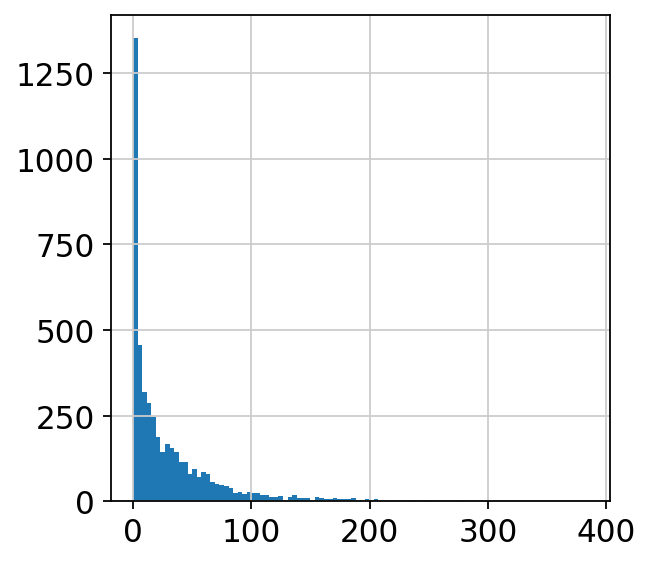

In [105]:
plt.hist(ct_df['NUM_CELLS'].values,bins=100);

#### Export

In [106]:
ct_df.drop(columns=['NUM_CELLS'],inplace=True)

In [107]:
path = prefix_mrna + 'pkls/pseudobulk_ct2.pkl'
# ct_df.to_pickle(path)
ct_df = pd.read_pickle(path)

### ADTs

#### Processing

Prepare `df`s.

In [41]:
ct_type = 'ct2'

In [42]:
raw_adts.obs = concat.obs.copy() # take the whole `.obs` because we need FID and COND as well

In [43]:
conds = concat.obs['cond'].dtype.categories
clusts = concat.obs[ct_type].dtype.categories

In [44]:
cond_ct_df = pd.DataFrame(index=conds, columns=clusts, dtype=np.int)

Get cell numbers.

In [45]:
for cond in tqdm(conds):
    for clust in clusts:
        cond_ct_df.loc[cond, clust] = concat[(concat.obs['cond'] == cond) & (concat.obs[ct_type] == clust)].shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

Divide by the total per cell type, then remove small populations we don't want to run DE on.

In [46]:
cond_ct_df_div = cond_ct_df.divide(cond_ct_df.sum(0),1)

In [47]:
high_count_cts = concat.obs[ct_type].value_counts().drop(['Plasma', 'Mitotic']).index.tolist()
print(high_count_cts)

['T4_Naive', 'T4_EM', 'cM', 'T8_Naive', 'T_Tox', 'B_Naive', 'NK', 'B_Mem', 'cDC', 'ncM', 'pDC', 'Mye_PMAI', 'HSC']


In [48]:
free_ids = np.unique(concat.obs['free_id'].values)
ind_ct = pd.DataFrame(0, index=free_ids, columns=high_count_cts)

In [49]:
for free_id, ct in tqdm(it.product(free_ids, high_count_cts)):
    ind_ct.loc[free_id, ct] = len(concat.obs[(concat.obs['free_id'] == free_id) & (concat.obs[ct_type] == ct)])

0it [00:00, ?it/s]

In [50]:
ct_cond_id = list(it.product(high_count_cts, ['A', 'B', 'C', 'G', 'P', 'R'], free_ids))

In [51]:
ct_cond_id_df = pd.DataFrame(ct_cond_id, columns=['CT','COND', 'FID'])

In [52]:
ct_cond_id_df

,CT,COND,FID
0,T4_Naive,A,0
1,T4_Naive,A,1
2,T4_Naive,A,10
3,T4_Naive,A,11
4,T4_Naive,A,12
...,...,...,...
4987,HSC,R,62
4988,HSC,R,63
4989,HSC,R,7
4990,HSC,R,8


Now get the actual transcript numbers.

In [53]:
counts_genes = list()
cell_counts = list()
for ct, cond, free_id in tqdm(ct_cond_id):
    arr = raw_adts[(raw_adts.obs[ct_type] == ct) & (raw_adts.obs['cond'] == cond) & (raw_adts.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

  0%|          | 0/4992 [00:00<?, ?it/s]

In [54]:
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_adts.var_names))

In [55]:
lot = list()
for i in ct_cond_id_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

In [56]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'Mye_PMAI-A', 'Mye_PMAI-B', 'Mye_PMAI-C', 'Mye_PMAI-G',
        'Mye_PMAI-P', 'Mye_PMAI-R', 'NK-A', 'NK-B', 'NK-C', 'NK-G', 'NK-P',
        'NK-R', 'T4_EM-A', 'T4_EM-B', 'T4_EM-C', 'T4_EM-G', 'T4_EM-P',
        'T4_EM-R', 'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C', 'T4_Naive-G',
        'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A', 'T8_Naive-B',
        'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P', 'T8_Naive-R', 'T_Tox-A',
        'T_Tox-B', 'T_Tox-C', 'T_Tox-G', 'T_Tox-P', 'T_Tox-R', 'cDC-A',
        'cDC-B', 'cDC-C', 'cDC-G', 'cDC-P', 'cDC-R', 'cM-A', 'cM-B',
        'cM-C', 'cM-G', 'cM-P', 'cM-R', 'ncM-A', 'ncM-B', 'ncM-C', 'ncM-G',
        'ncM-P', 'ncM-R', 'pDC-A', 'pDC-B', 'pDC-C', 'pDC-G', 'pDC-P',
        'pDC-R'], dtype='<U10'),
 array([64, 64, 64, 64, 64, 64, 

Because the PMA/I monocytes and cDCs (`Mye_PMAI`)didn't separate out and are grouped together in the final object, we still want to compare them to the other conditions but make sure the populations in other conditions are comparable. Therefore, I will make equivalent populations in the other conditions.

In [57]:
ct_cond_id_df[ct_cond_id_df['CT'] == 'Mye_PMAI']

,CT,COND,FID,NUM_CELLS,CD103|ITGAE,CD137|TNFRSF9,CD274|CD274,CD11b|ITGAM,CD39|ENTPD1,CD197|CCR7,...,CD49a|ITGA1,CD133|PROM,CD357|TNFRSF18,CD270|TNFRSF14,IL-21R|IL21R,B7-H4|VTCN1,CD26|DPP4,CD155|PVR,CD30|TNFRSF8,CD49E|ITGA5
4224,Mye_PMAI,A,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4225,Mye_PMAI,A,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4226,Mye_PMAI,A,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,Mye_PMAI,A,11,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4228,Mye_PMAI,A,12,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,Mye_PMAI,R,62,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4604,Mye_PMAI,R,63,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4605,Mye_PMAI,R,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4606,Mye_PMAI,R,8,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'Mye_PMAI') & (ct_cond_id_df['COND'].isin(['A','B','C','G','R'])))]

In [59]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'ncM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cDC') & (ct_cond_id_df['COND'] == 'P'))]

In [60]:
ct_cond_id_df['CT'] = ct_cond_id_df['CT'].str.replace('Mye_PMAI','M_cDC')

In [61]:
ct_cond_id_mono_cdc = list(it.product(['M_cDC'], ['A', 'B', 'C', 'G', 'R'], free_ids))

In [63]:
counts_genes_mono_cdc = list()
cell_counts_mono_cdc = list()
for ct, cond, free_id in tqdm(ct_cond_id_mono_cdc):
    arr = raw_adts[((raw_adts.obs[ct_type] == 'ncM') | 
                    (raw_adts.obs[ct_type] == 'cM') |
                    (raw_adts.obs[ct_type] == 'cDC')
                   ) & 
                   (raw_adts.obs['cond'] == cond) &
                   (raw_adts.obs['free_id'] == free_id)].X.toarray()
    cell_counts_mono_cdc.append(len(arr))
    counts_genes_mono_cdc.append(arr.sum(axis=0))

  0%|          | 0/320 [00:00<?, ?it/s]

In [64]:
ct_cond_id_mono_cdc_df = pd.DataFrame(ct_cond_id_mono_cdc, columns=['CT','COND', 'FID'])

In [65]:
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(cell_counts_mono_cdc),columns=['NUM_CELLS']))
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(counts_genes_mono_cdc),columns=raw_adts.var_names))

In [66]:
ct_df = pd.concat([ct_cond_id_df, ct_cond_id_mono_cdc_df])

Prepare for export.

In [67]:
lot = list()
for i in ct_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

Final checks:

In [68]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'M_cDC-A', 'M_cDC-B', 'M_cDC-C', 'M_cDC-G', 'M_cDC-P', 'M_cDC-R',
        'NK-A', 'NK-B', 'NK-C', 'NK-G', 'NK-P', 'NK-R', 'T4_EM-A',
        'T4_EM-B', 'T4_EM-C', 'T4_EM-G', 'T4_EM-P', 'T4_EM-R',
        'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C', 'T4_Naive-G',
        'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A', 'T8_Naive-B',
        'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P', 'T8_Naive-R', 'T_Tox-A',
        'T_Tox-B', 'T_Tox-C', 'T_Tox-G', 'T_Tox-P', 'T_Tox-R', 'cDC-A',
        'cDC-B', 'cDC-C', 'cDC-G', 'cDC-R', 'cM-A', 'cM-B', 'cM-C', 'cM-G',
        'cM-R', 'ncM-A', 'ncM-B', 'ncM-C', 'ncM-G', 'ncM-R', 'pDC-A',
        'pDC-B', 'pDC-C', 'pDC-G', 'pDC-P', 'pDC-R'], dtype='<U10'),
 array([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        

In [69]:
ct_cond_id_df['CT'].value_counts()

HSC         384
pDC         384
B_Naive     384
B_Mem       384
T8_Naive    384
T4_EM       384
NK          384
T4_Naive    384
T_Tox       384
cM          320
ncM         320
cDC         320
M_cDC        64
Name: CT, dtype: int64

In [70]:
ct_df.isna().sum().sum()

0

In [71]:
ct_df['CT'].value_counts()

HSC         384
pDC         384
M_cDC       384
B_Naive     384
B_Mem       384
T8_Naive    384
T4_EM       384
NK          384
T4_Naive    384
T_Tox       384
cM          320
ncM         320
cDC         320
Name: CT, dtype: int64

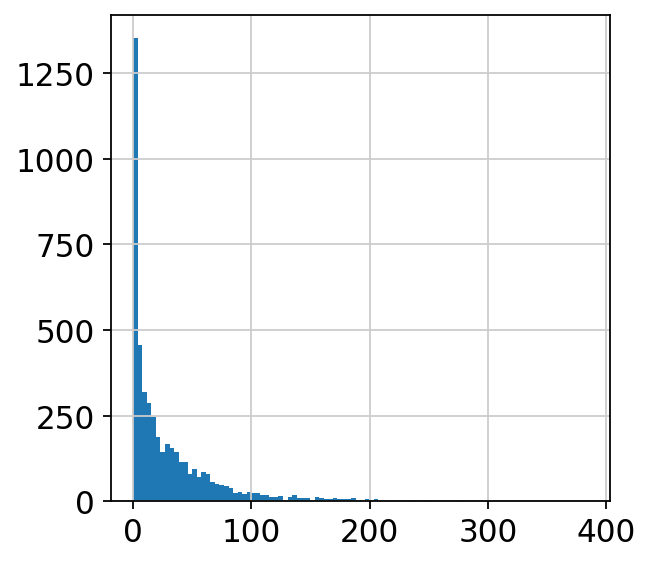

In [72]:
plt.hist(ct_df['NUM_CELLS'].values,bins=100);

#### Export

In [73]:
ct_df.drop(columns=['NUM_CELLS'],inplace=True)

In [74]:
path = prefix_adts + 'pkls/pseudobulk_ct2.pkl'
# ct_df.to_pickle(path)
ct_df = pd.read_pickle(path)

## `ct3`

### mRNA

#### Processing

Prepare `df`s.

In [108]:
ct_type = 'ct3'

In [109]:
raw_mrna.obs[ct_type] = concat.obs[ct_type]

Because we don't want to re-run on the cell types that are carried over from `ct2` to `ct3`, let's only focus on the clusters that are completely new.

In [110]:
conds = concat.obs['cond'].cat.categories
clusts = np.setdiff1d(concat.obs['ct3'].cat.categories.values,concat.obs['ct2'].cat.categories.values)

In [111]:
cond_ct_df = pd.DataFrame(index=conds, columns=clusts, dtype=np.int)

Get cell numbers.

In [112]:
for cond in tqdm(conds):
    for clust in clusts:
        cond_ct_df.loc[cond, clust] = concat[(concat.obs['cond'] == cond) & (concat.obs[ct_type] == clust)].shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

In the `ct3` annotations, there were some clusters that arose that were specific to only one or two conditions. For DE, I'm going to focus only on the ones that appeared in all the subclustered conditions (`C`, `A`, `G`, `B`, `R`).

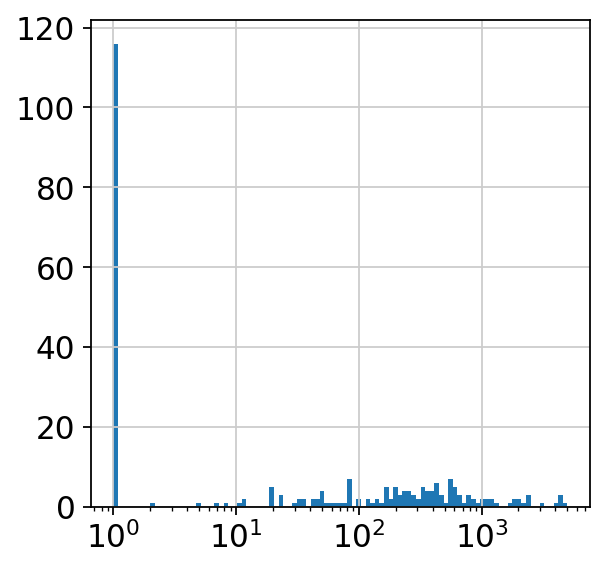

In [113]:
plt.hist(cond_ct_df.values.flatten() + 1, bins=np.logspace(np.log10(1), np.log10(5000), 100));
plt.xscale('log');

In [114]:
s = (cond_ct_df > 10).sum(0)
cond_ct_df = cond_ct_df[s[s == 5].index.values].copy()
cond_ct_df

,MAIT,NK_CD16+,NK_CD56++,T4_CM,T4_RA+_SELL+,T4_RA+_SELLint,T4_RO+_Act,T4_RO+_SELL+,T4_Treg_Act,T4_Treg_Resting,T8_CM,T8_EM,T8_HOBIT+HELIOS+,T8_RA+_SELL+,T8_TEMRA,T_CD10+,T_gd,cDC1,cDC2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
A,538.0,615.0,169.0,1031.0,4207.0,1926.0,553.0,1222.0,84.0,236.0,418.0,295.0,49.0,1733.0,254.0,45.0,395.0,100.0,118.0
B,590.0,560.0,223.0,755.0,4536.0,3039.0,654.0,1094.0,86.0,200.0,367.0,345.0,50.0,2496.0,260.0,35.0,402.0,228.0,85.0
C,594.0,914.0,196.0,1051.0,4512.0,2032.0,535.0,1297.0,86.0,223.0,359.0,289.0,67.0,1975.0,240.0,44.0,393.0,138.0,62.0
G,566.0,771.0,185.0,1104.0,4439.0,2154.0,526.0,1188.0,86.0,218.0,357.0,328.0,50.0,1896.0,258.0,19.0,436.0,170.0,98.0
P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R,638.0,338.0,161.0,569.0,4899.0,2352.0,608.0,833.0,113.0,267.0,339.0,287.0,76.0,2371.0,238.0,23.0,467.0,86.0,141.0


Divide by the total per cell type.

In [115]:
cond_ct_df_div = cond_ct_df.divide(cond_ct_df.sum(0),1)

In [116]:
high_count_cts = cond_ct_df.columns.values

In [117]:
free_ids = np.unique(concat.obs['free_id'].values)
ind_ct = pd.DataFrame(0, index=free_ids, columns=high_count_cts)

In [118]:
for free_id, ct in tqdm(it.product(free_ids, high_count_cts)):
    ind_ct.loc[free_id, ct] = len(concat.obs[(concat.obs['free_id'] == free_id) & (concat.obs[ct_type] == ct)])

0it [00:00, ?it/s]

The subclustering that was done to create `ct3` was only run on `C`, `A`, `G`, `B`, `R`, so I will only focus on those.

In [119]:
ct_cond_id = list(it.product(high_count_cts, ['A', 'B', 'C', 'G', 'R'], free_ids))

In [120]:
ct_cond_id_df = pd.DataFrame(ct_cond_id, columns=['CT','COND', 'FID'])

In [121]:
ct_cond_id_df

,CT,COND,FID
0,MAIT,A,0
1,MAIT,A,1
2,MAIT,A,10
3,MAIT,A,11
4,MAIT,A,12
...,...,...,...
6075,cDC2,R,62
6076,cDC2,R,63
6077,cDC2,R,7
6078,cDC2,R,8


Now get the actual transcript numbers.

In [122]:
counts_genes = list()
cell_counts = list()
for ct, cond, free_id in tqdm(ct_cond_id):
    arr = raw_mrna[(raw_mrna.obs[ct_type] == ct) & (raw_mrna.obs['cond'] == cond) & (raw_mrna.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

  0%|          | 0/6080 [00:00<?, ?it/s]

In [123]:
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_mrna.var_names))

In [124]:
ct_df = ct_cond_id_df

Prepare for export.

In [125]:
lot = list()
for i in ct_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

Final checks:

In [126]:
np.unique(lot, return_counts=True)

(array(['MAIT-A', 'MAIT-B', 'MAIT-C', 'MAIT-G', 'MAIT-R', 'NK_CD16+-A',
        'NK_CD16+-B', 'NK_CD16+-C', 'NK_CD16+-G', 'NK_CD16+-R',
        'NK_CD56++-A', 'NK_CD56++-B', 'NK_CD56++-C', 'NK_CD56++-G',
        'NK_CD56++-R', 'T4_CM-A', 'T4_CM-B', 'T4_CM-C', 'T4_CM-G',
        'T4_CM-R', 'T4_RA+_SELL+-A', 'T4_RA+_SELL+-B', 'T4_RA+_SELL+-C',
        'T4_RA+_SELL+-G', 'T4_RA+_SELL+-R', 'T4_RA+_SELLint-A',
        'T4_RA+_SELLint-B', 'T4_RA+_SELLint-C', 'T4_RA+_SELLint-G',
        'T4_RA+_SELLint-R', 'T4_RO+_Act-A', 'T4_RO+_Act-B', 'T4_RO+_Act-C',
        'T4_RO+_Act-G', 'T4_RO+_Act-R', 'T4_RO+_SELL+-A', 'T4_RO+_SELL+-B',
        'T4_RO+_SELL+-C', 'T4_RO+_SELL+-G', 'T4_RO+_SELL+-R',
        'T4_Treg_Act-A', 'T4_Treg_Act-B', 'T4_Treg_Act-C', 'T4_Treg_Act-G',
        'T4_Treg_Act-R', 'T4_Treg_Resting-A', 'T4_Treg_Resting-B',
        'T4_Treg_Resting-C', 'T4_Treg_Resting-G', 'T4_Treg_Resting-R',
        'T8_CM-A', 'T8_CM-B', 'T8_CM-C', 'T8_CM-G', 'T8_CM-R', 'T8_EM-A',
        'T8_EM-B', 'T8

In [127]:
ct_cond_id_df['CT'].value_counts()

T4_Treg_Act         320
T8_CM               320
T4_CM               320
T8_RA+_SELL+        320
T4_RO+_Act          320
cDC2                320
T_gd                320
NK_CD16+            320
T_CD10+             320
cDC1                320
T8_TEMRA            320
NK_CD56++           320
T8_HOBIT+HELIOS+    320
T4_RA+_SELLint      320
T8_EM               320
MAIT                320
T4_RO+_SELL+        320
T4_RA+_SELL+        320
T4_Treg_Resting     320
Name: CT, dtype: int64

In [128]:
ct_df.isna().sum().sum()

0

In [129]:
ct_df['CT'].value_counts()

T4_Treg_Act         320
T8_CM               320
T4_CM               320
T8_RA+_SELL+        320
T4_RO+_Act          320
cDC2                320
T_gd                320
NK_CD16+            320
T_CD10+             320
cDC1                320
T8_TEMRA            320
NK_CD56++           320
T8_HOBIT+HELIOS+    320
T4_RA+_SELLint      320
T8_EM               320
MAIT                320
T4_RO+_SELL+        320
T4_RA+_SELL+        320
T4_Treg_Resting     320
Name: CT, dtype: int64

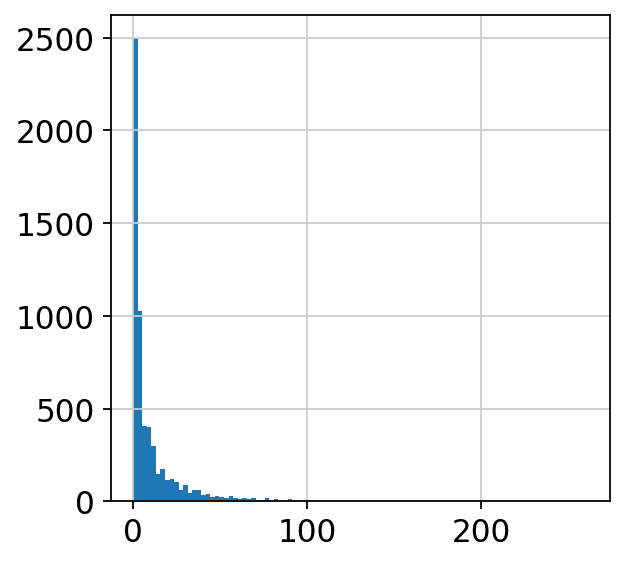

In [130]:
plt.hist(ct_df['NUM_CELLS'].values,bins=100);

#### Export

In [131]:
ct_df.drop(columns=['NUM_CELLS'],inplace=True)

In [132]:
path = prefix_mrna + 'pkls/pseudobulk_ct3.pkl'
# ct_df.to_pickle(path)
ct_df = pd.read_pickle(path)

### ADTs

#### Processing

Prepare `df`s.

In [133]:
ct_type = 'ct3'

In [134]:
raw_adts.obs = concat.obs.copy()

Because we don't want to re-run on the cell types that are carried over from `ct2` to `ct3`, let's only focus on the clusters that are completely new.

In [135]:
conds = concat.obs['cond'].cat.categories
clusts = np.setdiff1d(concat.obs['ct3'].cat.categories.values,concat.obs['ct2'].cat.categories.values)

In [136]:
cond_ct_df = pd.DataFrame(index=conds, columns=clusts, dtype=np.int)

Get cell numbers.

In [137]:
for cond in tqdm(conds):
    for clust in clusts:
        cond_ct_df.loc[cond, clust] = concat[(concat.obs['cond'] == cond) & (concat.obs[ct_type] == clust)].shape[0]

  0%|          | 0/7 [00:00<?, ?it/s]

In the `ct3` annotations, there were some clusters that arose that were specific to only one or two conditions. For DE, I'm going to focus only on the ones that appeared in all the subclustered conditions (`C`, `A`, `G`, `B`, `R`).

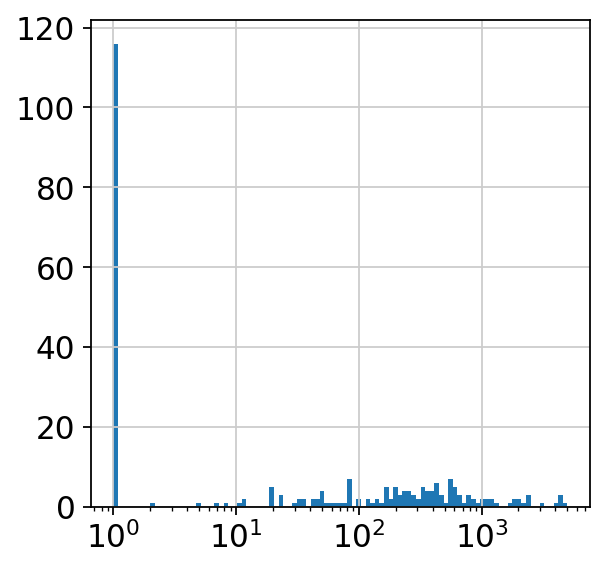

In [138]:
plt.hist(cond_ct_df.values.flatten() + 1, bins=np.logspace(np.log10(1), np.log10(5000), 100));
plt.xscale('log');

In [139]:
s = (cond_ct_df > 10).sum(0)
cond_ct_df = cond_ct_df[s[s == 5].index.values].copy()
cond_ct_df

,MAIT,NK_CD16+,NK_CD56++,T4_CM,T4_RA+_SELL+,T4_RA+_SELLint,T4_RO+_Act,T4_RO+_SELL+,T4_Treg_Act,T4_Treg_Resting,T8_CM,T8_EM,T8_HOBIT+HELIOS+,T8_RA+_SELL+,T8_TEMRA,T_CD10+,T_gd,cDC1,cDC2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
A,538.0,615.0,169.0,1031.0,4207.0,1926.0,553.0,1222.0,84.0,236.0,418.0,295.0,49.0,1733.0,254.0,45.0,395.0,100.0,118.0
B,590.0,560.0,223.0,755.0,4536.0,3039.0,654.0,1094.0,86.0,200.0,367.0,345.0,50.0,2496.0,260.0,35.0,402.0,228.0,85.0
C,594.0,914.0,196.0,1051.0,4512.0,2032.0,535.0,1297.0,86.0,223.0,359.0,289.0,67.0,1975.0,240.0,44.0,393.0,138.0,62.0
G,566.0,771.0,185.0,1104.0,4439.0,2154.0,526.0,1188.0,86.0,218.0,357.0,328.0,50.0,1896.0,258.0,19.0,436.0,170.0,98.0
P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R,638.0,338.0,161.0,569.0,4899.0,2352.0,608.0,833.0,113.0,267.0,339.0,287.0,76.0,2371.0,238.0,23.0,467.0,86.0,141.0


Divide by the total per cell type.

In [140]:
cond_ct_df_div = cond_ct_df.divide(cond_ct_df.sum(0),1)

In [141]:
high_count_cts = cond_ct_df.columns.values

In [142]:
free_ids = np.unique(concat.obs['free_id'].values)
ind_ct = pd.DataFrame(0, index=free_ids, columns=high_count_cts)

In [143]:
for free_id, ct in tqdm(it.product(free_ids, high_count_cts)):
    ind_ct.loc[free_id, ct] = len(concat.obs[(concat.obs['free_id'] == free_id) & (concat.obs[ct_type] == ct)])

0it [00:00, ?it/s]

The subclustering that was done to create `ct3` was only run on `C`, `A`, `G`, `B`, `R`, so I will only focus on those.

In [144]:
ct_cond_id = list(it.product(high_count_cts, ['A', 'B', 'C', 'G', 'R'], free_ids))

In [145]:
ct_cond_id_df = pd.DataFrame(ct_cond_id, columns=['CT','COND', 'FID'])

In [146]:
ct_cond_id_df

,CT,COND,FID
0,MAIT,A,0
1,MAIT,A,1
2,MAIT,A,10
3,MAIT,A,11
4,MAIT,A,12
...,...,...,...
6075,cDC2,R,62
6076,cDC2,R,63
6077,cDC2,R,7
6078,cDC2,R,8


Now get the actual transcript numbers.

In [147]:
counts_genes = list()
cell_counts = list()
for ct, cond, free_id in tqdm(ct_cond_id):
    arr = raw_adts[(raw_adts.obs[ct_type] == ct) & (raw_adts.obs['cond'] == cond) & (raw_adts.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

  0%|          | 0/6080 [00:00<?, ?it/s]

In [148]:
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_adts.var_names))

In [149]:
ct_df = ct_cond_id_df

Prepare for export.

In [150]:
lot = list()
for i in ct_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

Final checks:

In [151]:
np.unique(lot, return_counts=True)

(array(['MAIT-A', 'MAIT-B', 'MAIT-C', 'MAIT-G', 'MAIT-R', 'NK_CD16+-A',
        'NK_CD16+-B', 'NK_CD16+-C', 'NK_CD16+-G', 'NK_CD16+-R',
        'NK_CD56++-A', 'NK_CD56++-B', 'NK_CD56++-C', 'NK_CD56++-G',
        'NK_CD56++-R', 'T4_CM-A', 'T4_CM-B', 'T4_CM-C', 'T4_CM-G',
        'T4_CM-R', 'T4_RA+_SELL+-A', 'T4_RA+_SELL+-B', 'T4_RA+_SELL+-C',
        'T4_RA+_SELL+-G', 'T4_RA+_SELL+-R', 'T4_RA+_SELLint-A',
        'T4_RA+_SELLint-B', 'T4_RA+_SELLint-C', 'T4_RA+_SELLint-G',
        'T4_RA+_SELLint-R', 'T4_RO+_Act-A', 'T4_RO+_Act-B', 'T4_RO+_Act-C',
        'T4_RO+_Act-G', 'T4_RO+_Act-R', 'T4_RO+_SELL+-A', 'T4_RO+_SELL+-B',
        'T4_RO+_SELL+-C', 'T4_RO+_SELL+-G', 'T4_RO+_SELL+-R',
        'T4_Treg_Act-A', 'T4_Treg_Act-B', 'T4_Treg_Act-C', 'T4_Treg_Act-G',
        'T4_Treg_Act-R', 'T4_Treg_Resting-A', 'T4_Treg_Resting-B',
        'T4_Treg_Resting-C', 'T4_Treg_Resting-G', 'T4_Treg_Resting-R',
        'T8_CM-A', 'T8_CM-B', 'T8_CM-C', 'T8_CM-G', 'T8_CM-R', 'T8_EM-A',
        'T8_EM-B', 'T8

In [152]:
ct_cond_id_df['CT'].value_counts()

T4_Treg_Act         320
T8_CM               320
T4_CM               320
T8_RA+_SELL+        320
T4_RO+_Act          320
cDC2                320
T_gd                320
NK_CD16+            320
T_CD10+             320
cDC1                320
T8_TEMRA            320
NK_CD56++           320
T8_HOBIT+HELIOS+    320
T4_RA+_SELLint      320
T8_EM               320
MAIT                320
T4_RO+_SELL+        320
T4_RA+_SELL+        320
T4_Treg_Resting     320
Name: CT, dtype: int64

In [153]:
ct_df.isna().sum().sum()

0

In [154]:
ct_df['CT'].value_counts()

T4_Treg_Act         320
T8_CM               320
T4_CM               320
T8_RA+_SELL+        320
T4_RO+_Act          320
cDC2                320
T_gd                320
NK_CD16+            320
T_CD10+             320
cDC1                320
T8_TEMRA            320
NK_CD56++           320
T8_HOBIT+HELIOS+    320
T4_RA+_SELLint      320
T8_EM               320
MAIT                320
T4_RO+_SELL+        320
T4_RA+_SELL+        320
T4_Treg_Resting     320
Name: CT, dtype: int64

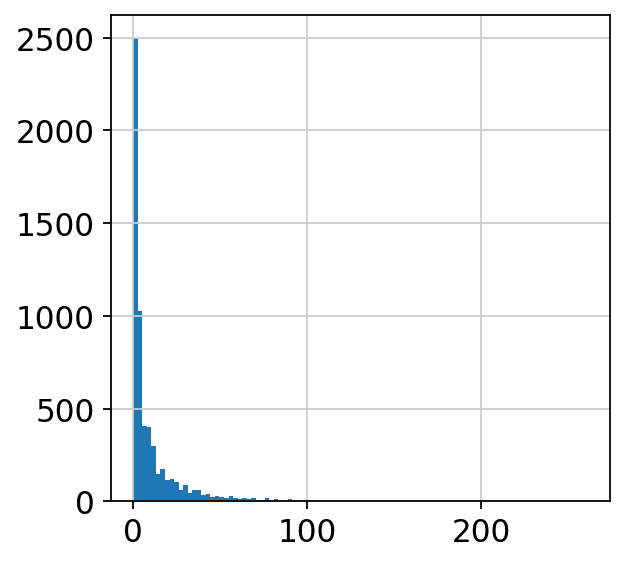

In [155]:
plt.hist(ct_df['NUM_CELLS'].values,bins=100);

#### Export

In [156]:
ct_df.drop(columns=['NUM_CELLS'],inplace=True)

In [157]:
path = prefix_adts + 'pkls/pseudobulk_ct3.pkl'
# ct_df.to_pickle(path)
ct_df = pd.read_pickle(path)